In [2]:
import numpy as np
import torch
import random


SEED = 404
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Analisis Tools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Model package
from darts import TimeSeries
from darts.models import ARIMA

d:\MiniConda\envs\torch_gpu\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
d:\MiniConda\envs\torch_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data Preparation

In [4]:
colors = ['#1A73E8', '#34A853', '#FBBC04', '#EA4335', '#9AA0A6']
brands = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']

In [5]:
urlData = "https://raw.githubusercontent.com/zzahranez/otomotive-forecasting/zahran/data/dataCarSale2010-2025.csv"
df = pd.read_csv('../../data/dataCarSale2010-2025.csv')

In [6]:
print(df.head(15))

        waktu  DAIHATSU   HONDA  MITSUBISHI  SUZUKI   TOYOTA
0    1/1/2010    8302.0  3755.0      6855.0  4815.0  20798.0
1    2/1/2010    7518.0  4431.0      8246.0  4638.0  21753.0
2    3/1/2010    8084.0  5179.0      9068.0  6203.0  26222.0
3    4/1/2010    9298.0  5154.0      9560.0  6013.0  24381.0
4    5/1/2010    9485.0  4439.0      9544.0  6043.0  21024.0
5    6/1/2010   11886.0  5965.0      8875.0  6704.0  26006.0
6    7/1/2010   11524.0  6006.0      9586.0  5623.0  27737.0
7    8/1/2010    9741.0  6025.0      9310.0  6063.0  22638.0
8    9/1/2010    6652.0  3504.0      7299.0  4924.0  18413.0
9   10/1/2010   10708.0  5970.0      9407.0  7015.0  25322.0
10  11/1/2010   12932.0  5750.0      9791.0  7003.0  22623.0
11  12/1/2010   12461.0  5158.0      8942.0  6166.0  23763.0
12   1/1/2011   12590.0  4928.0     10673.0  6630.0  27619.0
13   2/1/2011    9958.0  4558.0     10480.0  6802.0  25532.0
14   3/1/2011   10186.0  4193.0     13074.0  8016.0  32275.0


In [7]:
df.describe()

,DAIHATSU,HONDA,MITSUBISHI,SUZUKI,TOYOTA
count,186.000000,186.000000,186.000000,186.000000,186.000000
mean,12980.665097,9349.760946,10261.675344,8199.528495,25853.107027
std,4262.144988,4739.907180,3546.637635,3311.661954,8567.811582
min,0.000000,101.000000,919.000000,779.000000,695.000000
25%,9505.750000,5049.000000,7329.750000,6178.250000,21358.750000
50%,14125.500000,9353.500000,10150.000000,8109.000000,27090.000000
75%,15926.250000,13239.500000,12820.750000,10017.000000,31952.000000
max,23165.000000,19339.000000,19341.000000,16903.000000,40781.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   waktu       186 non-null    object 
 1   DAIHATSU    186 non-null    float64
 2   HONDA       186 non-null    float64
 3   MITSUBISHI  186 non-null    float64
 4   SUZUKI      186 non-null    float64
 5   TOYOTA      186 non-null    float64
dtypes: float64(5), object(1)
memory usage: 8.8+ KB


### a. Convert to datetime

In [9]:
df['waktu'] = pd.to_datetime(df['waktu'], format="%m/%d/%Y")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   waktu       186 non-null    datetime64[ns]
 1   DAIHATSU    186 non-null    float64       
 2   HONDA       186 non-null    float64       
 3   MITSUBISHI  186 non-null    float64       
 4   SUZUKI      186 non-null    float64       
 5   TOYOTA      186 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 8.8 KB


In [11]:
df.set_index('waktu', inplace=True)

In [12]:
print(df.head())

            DAIHATSU   HONDA  MITSUBISHI  SUZUKI   TOYOTA
waktu                                                    
2010-01-01    8302.0  3755.0      6855.0  4815.0  20798.0
2010-02-01    7518.0  4431.0      8246.0  4638.0  21753.0
2010-03-01    8084.0  5179.0      9068.0  6203.0  26222.0
2010-04-01    9298.0  5154.0      9560.0  6013.0  24381.0
2010-05-01    9485.0  4439.0      9544.0  6043.0  21024.0


### b List Declaration

In [13]:
df.isna().sum()

DAIHATSU      0
HONDA         0
MITSUBISHI    0
SUZUKI        0
TOYOTA        0
dtype: int64

In [14]:
print(df[165:170])

            DAIHATSU      HONDA  MITSUBISHI  SUZUKI     TOYOTA
waktu                                                         
2023-10-01  8208.000  11307.000    6690.000  5502.0  21298.000
2023-11-01  7466.000  10307.000    6600.000  6602.0  24622.000
2024-01-01  7348.196   3222.119    5076.613  3242.0  10366.353
2024-02-01  6021.329   3829.318    4349.666  2999.0  10770.845
2024-03-01  6591.920   5212.549    4708.298  3503.0  12301.583


In [15]:
all_months = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')

In [16]:
print(all_months)

DatetimeIndex(['2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01',
               ...
               '2024-10-01', '2024-11-01', '2024-12-01', '2025-01-01',
               '2025-02-01', '2025-03-01', '2025-04-01', '2025-05-01',
               '2025-06-01', '2025-07-01'],
              dtype='datetime64[ns]', length=187, freq='MS')


In [17]:
df = df.reindex(all_months)

In [18]:
df.isna().sum()

DAIHATSU      1
HONDA         1
MITSUBISHI    1
SUZUKI        1
TOYOTA        1
dtype: int64

In [19]:
df = df.interpolate(method='linear')

In [20]:
print("data Setelah imputasi: \n")
print(df[165:170])

data Setelah imputasi: 

            DAIHATSU       HONDA  MITSUBISHI  SUZUKI      TOYOTA
2023-10-01  8208.000  11307.0000   6690.0000  5502.0  21298.0000
2023-11-01  7466.000  10307.0000   6600.0000  6602.0  24622.0000
2023-12-01  7407.098   6764.5595   5838.3065  4922.0  17494.1765
2024-01-01  7348.196   3222.1190   5076.6130  3242.0  10366.3530
2024-02-01  6021.329   3829.3180   4349.6660  2999.0  10770.8450


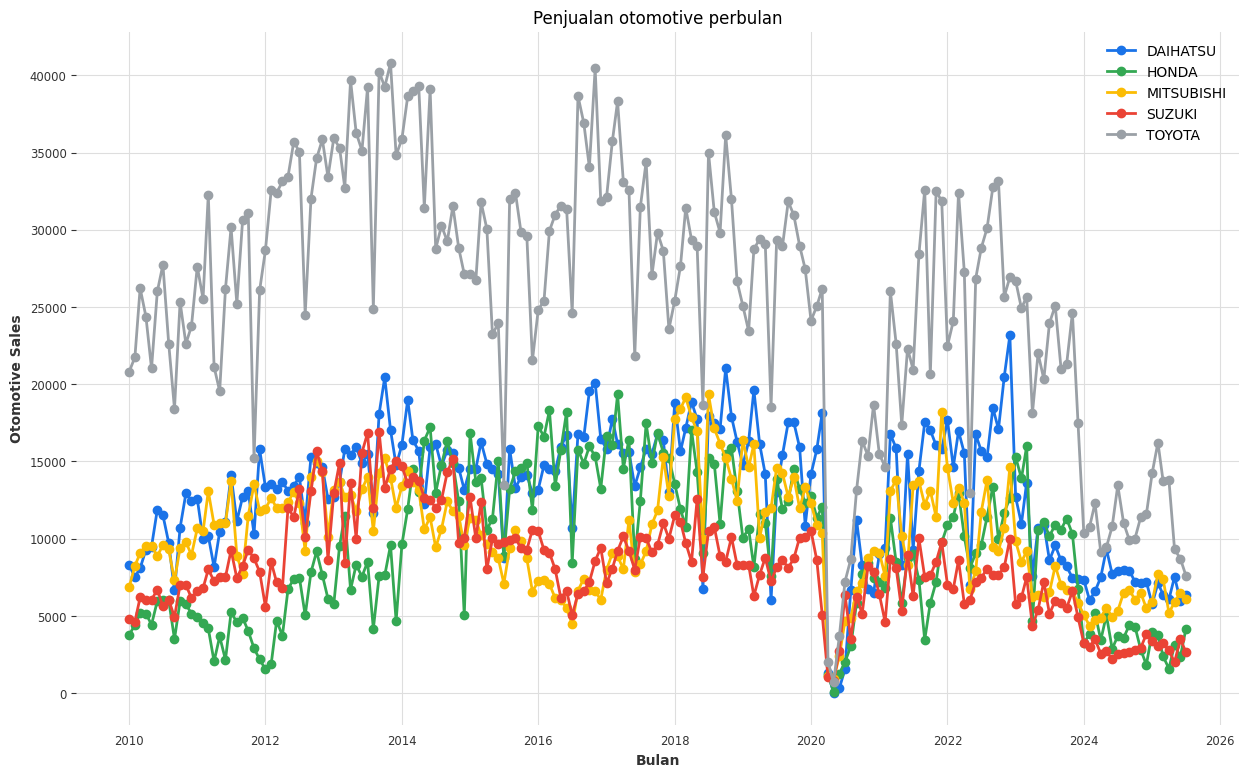

In [21]:
plt.figure(figsize=(15,9))
for i, brand in enumerate(brands):
    plt.plot(df.index, df[brand], marker='o', color=colors[i], label=brand, linewidth=2.0)
plt.title('Penjualan otomotive perbulan')
plt.xlabel('Bulan')
plt.ylabel('Otomotive Sales')
plt.grid(True)
plt.legend()
plt.show()

In [22]:
print(df.head(1))

            DAIHATSU   HONDA  MITSUBISHI  SUZUKI   TOYOTA
2010-01-01    8302.0  3755.0      6855.0  4815.0  20798.0


In [23]:
# for brand in brands:
#     df[brand] = df[brand].round(0)

In [24]:
print(df.tail())

            DAIHATSU     HONDA  MITSUBISHI    SUZUKI     TOYOTA
2025-03-01  6371.692  2382.924      7380.0  3223.220  13711.773
2025-04-01  6075.811  1590.411      5197.0  2767.379  13779.300
2025-05-01  7537.632  3148.000      5897.0  2004.813   9313.266
2025-06-01  5992.367  2360.797      6501.0  3499.336   8712.383
2025-07-01  6354.101  4171.007      6121.0  2666.235   7617.122


# 2. Uji Seasonal

### a. With Plot

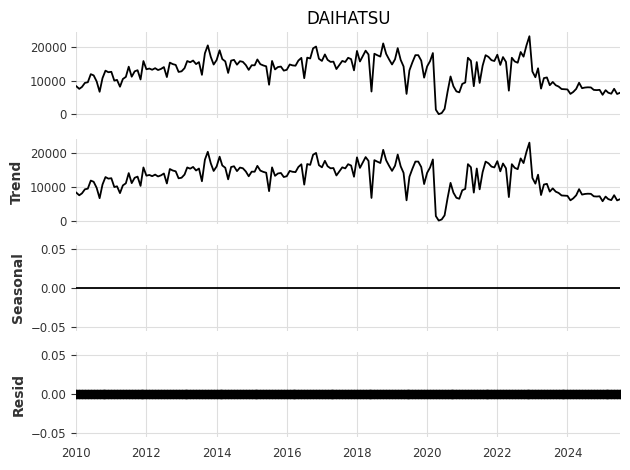

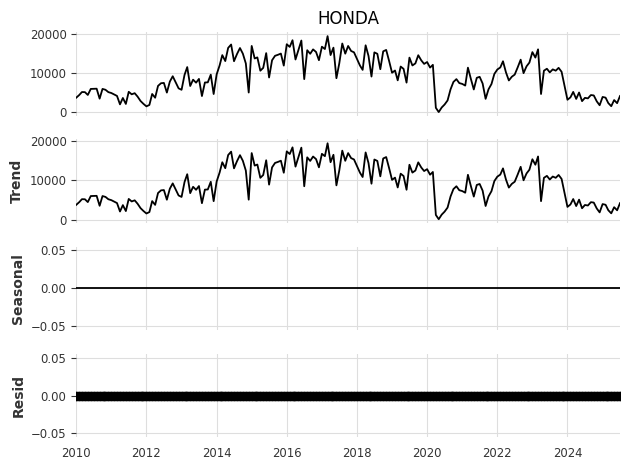

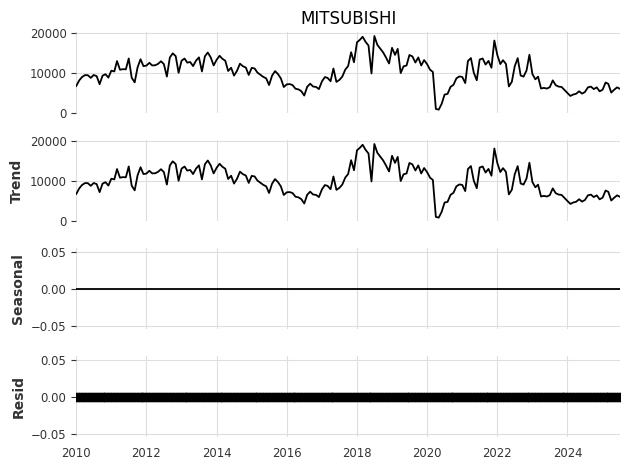

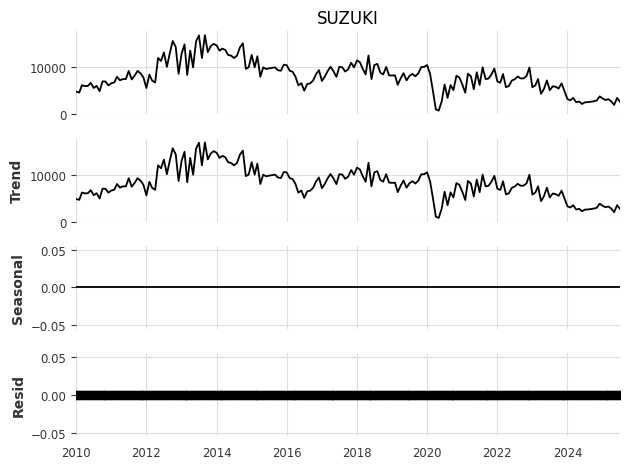

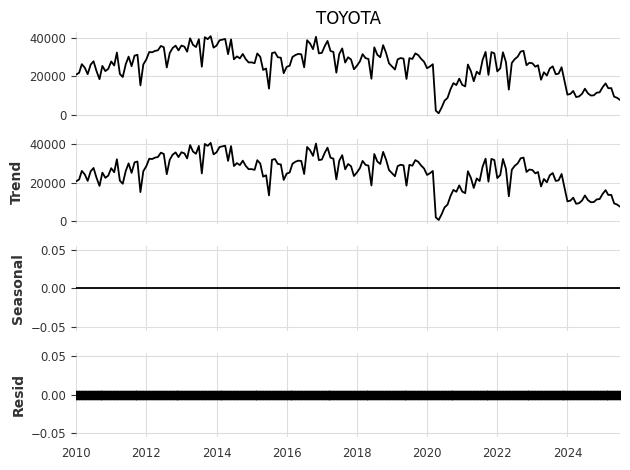

In [25]:
for i, brand in enumerate(brands):
    result = seasonal_decompose(df[brand], model='additive', period=1)
    result.plot()
    plt.show()

# 3. Uji Stasioneritas And Handle Data Has Not Stationers

### a. Augmention Dicky Fuller

In [26]:
def adf_test(timeseries, name=""):
    print(f"=== ADF Test for {name} ===")
    print("==============================")
    
    result = adfuller(timeseries.dropna())
    
    hasil_adf = pd.Series(result[0:4], 
                          index=["Test Statistic", "p-value", "Lags Used", "Number of Observations Used"])
    
    for key, value in result[4].items():
        hasil_adf[f"Critical Value ({key})"] = value
    
    print(hasil_adf, "\n")
    
    if result[1] <= 0.05:
        print("✅ Data stasioner (tolak H0)\n")
    else:
        print("❌ Data tidak stasioner (gagal tolak H0)\n")


In [27]:
for brand in brands:
    adf_test(df[brand], name=brand)

=== ADF Test for DAIHATSU ===
Test Statistic                  -1.827938
p-value                          0.366682
Lags Used                       12.000000
Number of Observations Used    174.000000
Critical Value (1%)             -3.468502
Critical Value (5%)             -2.878298
Critical Value (10%)            -2.575704
dtype: float64 

❌ Data tidak stasioner (gagal tolak H0)

=== ADF Test for HONDA ===
Test Statistic                  -1.351039
p-value                          0.605511
Lags Used                       13.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
Critical Value (10%)            -2.575756
dtype: float64 

❌ Data tidak stasioner (gagal tolak H0)

=== ADF Test for MITSUBISHI ===
Test Statistic                  -2.960544
p-value                          0.038747
Lags Used                       12.000000
Number of Observations Used    174.000000
Critical Value (1%)             -3.4685

#### from dicket fuller function data has five columns has not stationer except SUZUKI

### b Differencing 1

In [28]:
print(df.head(1))

            DAIHATSU   HONDA  MITSUBISHI  SUZUKI   TOYOTA
2010-01-01    8302.0  3755.0      6855.0  4815.0  20798.0


In [29]:
brands_notstasioners = ["DAIHATSU", "HONDA", "MITSUBISHI", "TOYOTA"]

In [30]:
df_diff = df.copy()

In [31]:
# df_diff.drop(columns="SUZUKI",axis=1, inplace=True)

In [32]:
print(df_diff.head(3))

            DAIHATSU   HONDA  MITSUBISHI  SUZUKI   TOYOTA
2010-01-01    8302.0  3755.0      6855.0  4815.0  20798.0
2010-02-01    7518.0  4431.0      8246.0  4638.0  21753.0
2010-03-01    8084.0  5179.0      9068.0  6203.0  26222.0


In [33]:
df_diff = df_diff.diff().dropna()

In [34]:
print(df_diff.head(2))

            DAIHATSU  HONDA  MITSUBISHI  SUZUKI  TOYOTA
2010-02-01    -784.0  676.0      1391.0  -177.0   955.0
2010-03-01     566.0  748.0       822.0  1565.0  4469.0


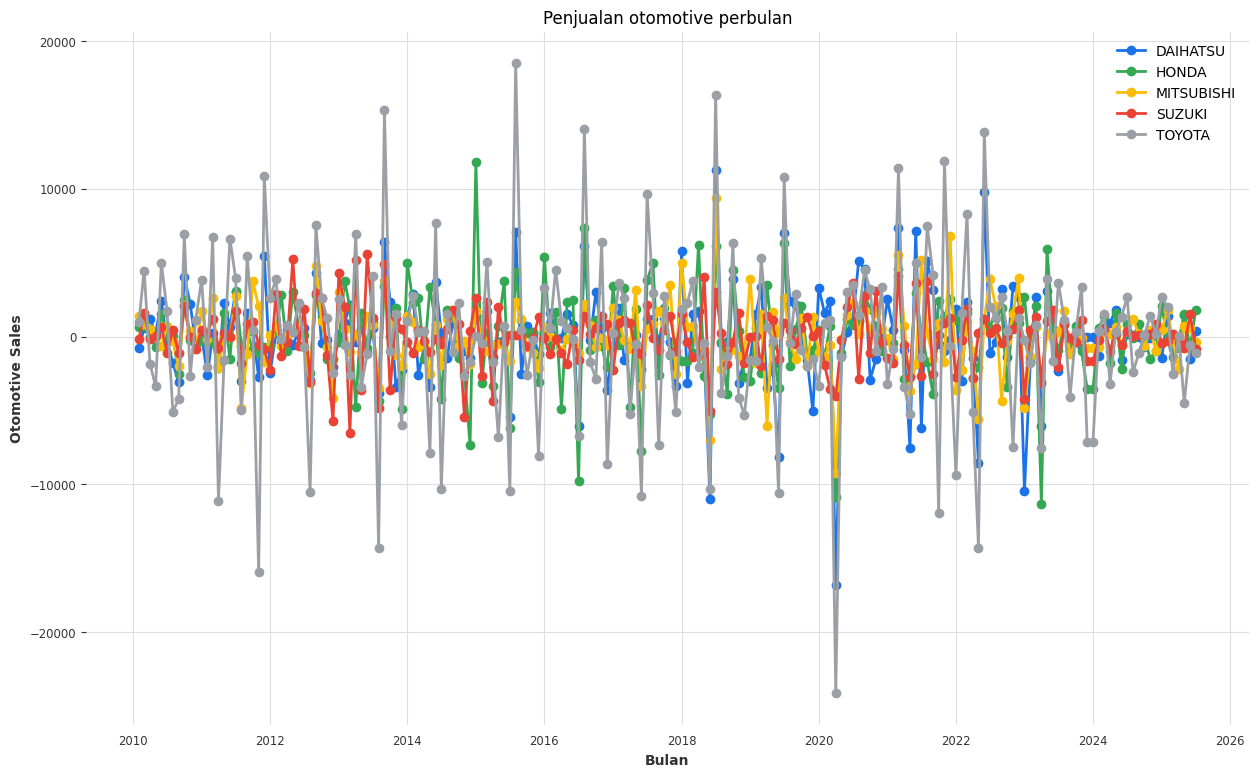

In [35]:
plt.figure(figsize=(15,9))
for i, brand in enumerate(brands):
    plt.plot(df_diff.index, df_diff[brand], marker='o', color=colors[i], label=brand, linewidth=2.0)
plt.title('Penjualan otomotive perbulan')
plt.xlabel('Bulan')
plt.ylabel('Otomotive Sales')
plt.grid(True)
plt.legend()
plt.show()

### c. Stasioners Testing

In [36]:
for brand in brands:
    adf_test(df_diff[brand], name=brand)

=== ADF Test for DAIHATSU ===
Test Statistic                  -4.631320
p-value                          0.000113
Lags Used                       11.000000
Number of Observations Used    174.000000
Critical Value (1%)             -3.468502
Critical Value (5%)             -2.878298
Critical Value (10%)            -2.575704
dtype: float64 

✅ Data stasioner (tolak H0)

=== ADF Test for HONDA ===
Test Statistic                  -4.687041
p-value                          0.000089
Lags Used                       12.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
Critical Value (10%)            -2.575756
dtype: float64 

✅ Data stasioner (tolak H0)

=== ADF Test for MITSUBISHI ===
Test Statistic                  -3.441165
p-value                          0.009633
Lags Used                       11.000000
Number of Observations Used    174.000000
Critical Value (1%)             -3.468502
Critical Value (5%)  

In [37]:
print(df.head(1))

            DAIHATSU   HONDA  MITSUBISHI  SUZUKI   TOYOTA
2010-01-01    8302.0  3755.0      6855.0  4815.0  20798.0


# 4. Find orde value p and q

<Figure size 1200x600 with 0 Axes>

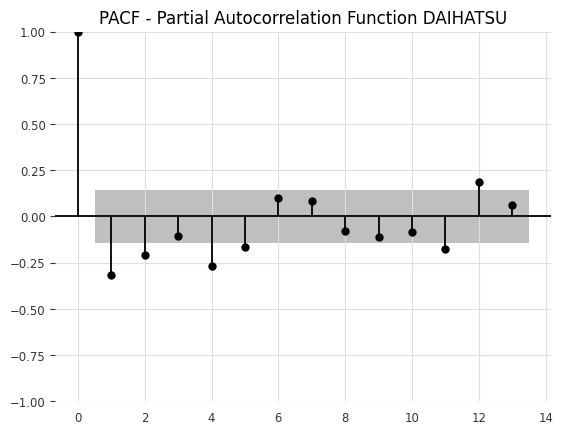

<Figure size 1200x600 with 0 Axes>

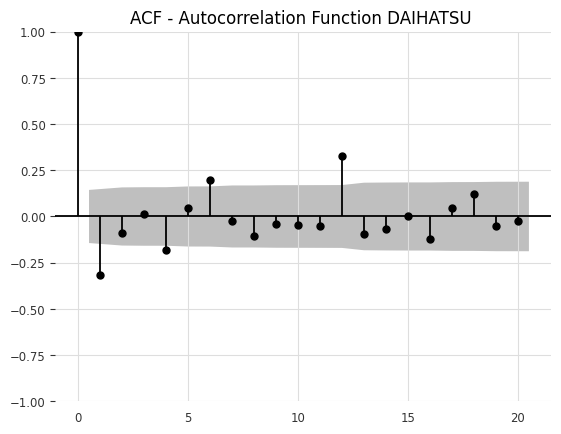

<Figure size 1200x600 with 0 Axes>

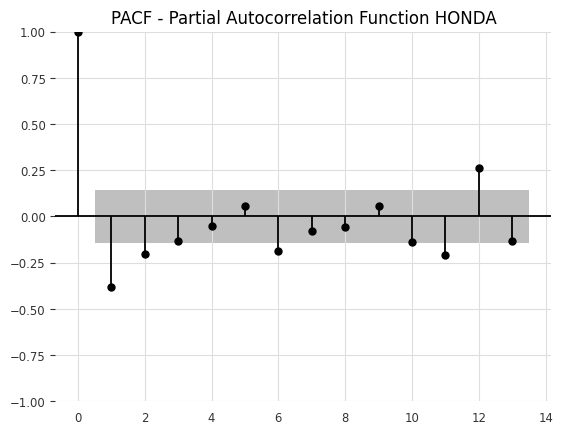

<Figure size 1200x600 with 0 Axes>

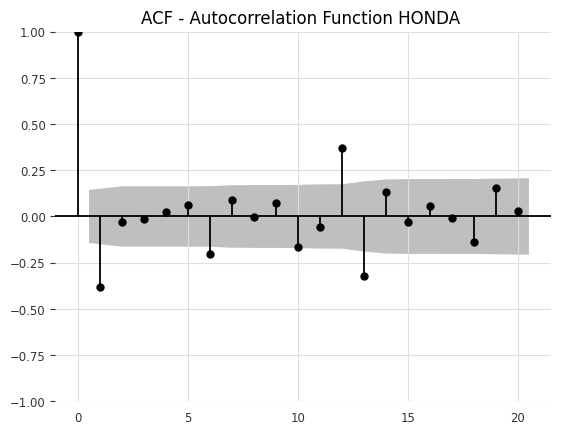

<Figure size 1200x600 with 0 Axes>

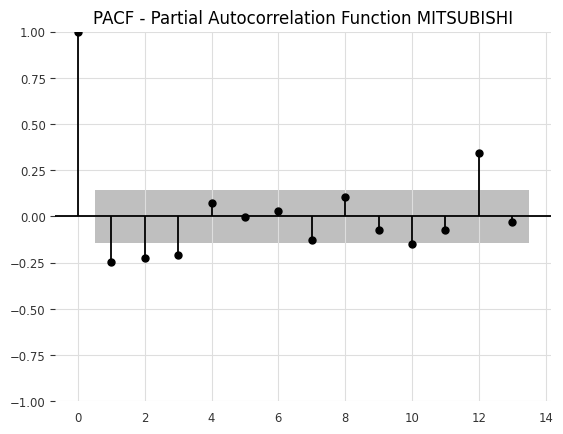

<Figure size 1200x600 with 0 Axes>

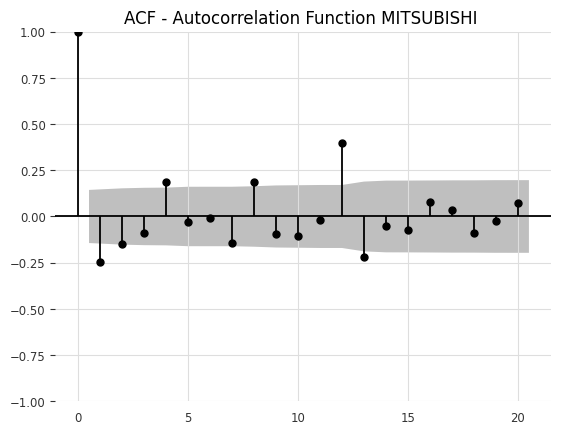

<Figure size 1200x600 with 0 Axes>

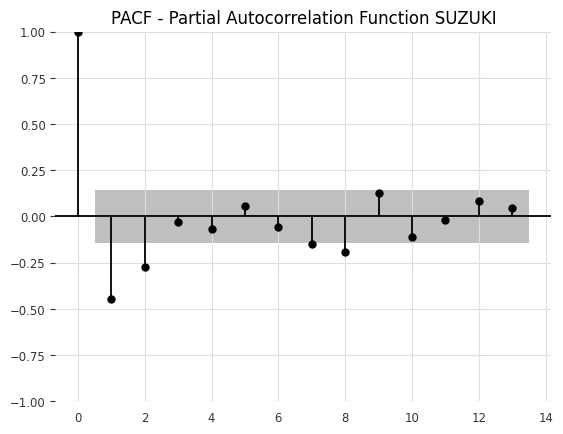

<Figure size 1200x600 with 0 Axes>

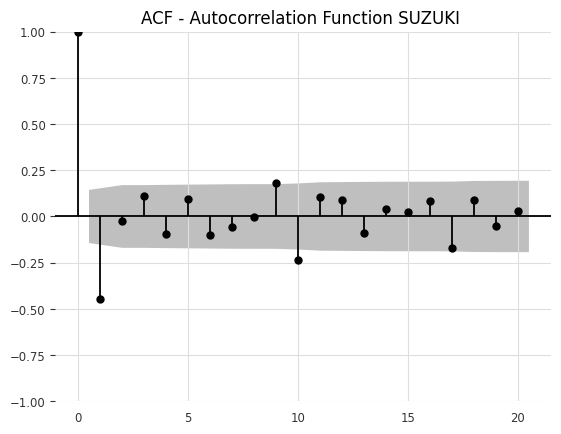

<Figure size 1200x600 with 0 Axes>

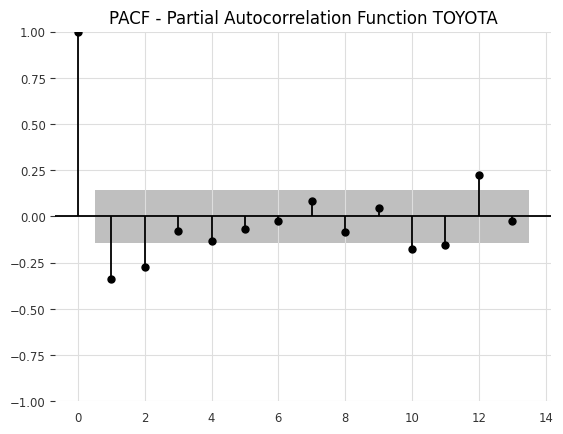

<Figure size 1200x600 with 0 Axes>

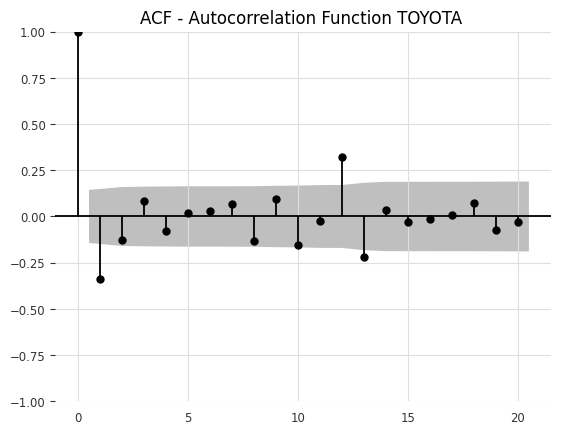

In [38]:
for brand in brands:
    plt.figure(figsize=(12, 6))
    plot_pacf(df_diff[brand], lags=13)    
    plt.title(f'PACF - Partial Autocorrelation Function {brand}')
    plt.show()

    plt.figure(figsize=(12, 6))
    plot_acf(df_diff[brand], lags=20)
    plt.title(f'ACF - Autocorrelation Function {brand} ')
    plt.show()

# 5. Modelling

In [39]:
from darts.metrics import smape

In [40]:
def backtesting(p,d,q,seriesset):
    model = ARIMA(p, d, q)

    backtest_forecast = model.backtest(
    series=seriesset,      
    start=0.8,               
    forecast_horizon=1,     
    metric=smape,            
    verbose=False
    )
    print(f"Rata-rata sMAPE backtesting: {backtest_forecast:.2f}%")

### a. Daihatsu

In [41]:
ts_Daihatsu = TimeSeries.from_series(
    df['DAIHATSU'],
    fill_missing_dates=True,
    freq=None
)

# Split Data To Testing
horizon = 6
# train, test = ts_Daihatsu[:-6], ts_Daihatsu[-6:]
train, test = ts_Daihatsu[:-1], ts_Daihatsu[-1:]

In [42]:
print("Train Data", df['DAIHATSU'][40:-1])
print("Testing data : ",df['DAIHATSU'][-1:])

Train Data 2013-05-01    15941.000
2013-06-01    14882.000
2013-07-01    15477.000
2013-08-01    11689.000
2013-09-01    18099.000
                ...    
2025-02-01     7126.837
2025-03-01     6371.692
2025-04-01     6075.811
2025-05-01     7537.632
2025-06-01     5992.367
Freq: MS, Name: DAIHATSU, Length: 146, dtype: float64
Testing data :  2025-07-01    6354.101
Freq: MS, Name: DAIHATSU, dtype: float64


In [43]:
model_arima = ARIMA(2,1,2)
model_arima.fit(train)

forecast_july = model_arima.predict(1)

# Perform Accuracy with sMape
july_smape = smape(test, forecast_july)
accuracy = 100 - july_smape

print("   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---")
print(f"sMAPE untuk Juli 2025: {july_smape:.2f}%")
print(f"Accurayy : {accuracy:.2f}%")
# Compare Accuracy 
print("Nilai aktual Juli 2025 :", test.values()[0][0])
print("Forecast Juli 2025     :", forecast_july.values()[0][0])

print("\n", "-"*50)
print("\t---> PREDIKSI UTAMA <---")

# ---> Re Train for count full data until july 2025
arima_model_full = ARIMA(2, 1, 2)
arima_model_full.fit(ts_Daihatsu)

forecast_august = arima_model_full.predict(1)
print("Prediksi Agustus 2025 :", forecast_august.values()[0][0])


# Convert forecast ke pandas Series (nilai asli, tidak differenced)
forecast_august = arima_model_full.predict(1)  # Forecast level

   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---
sMAPE untuk Juli 2025: 0.91%
Accurayy : 99.09%
Nilai aktual Juli 2025 : 6354.101
Forecast Juli 2025     : 6412.44999151218

 --------------------------------------------------
	---> PREDIKSI UTAMA <---
Prediksi Agustus 2025 : 6508.0802744517605


### b. Honda

In [44]:
ts_Honda = TimeSeries.from_series(
    df['HONDA'],
    fill_missing_dates=True,
    freq=None
)

# Split Data To Testing
horizon = 6
# train, test = ts_Honda[:-6], ts_Honda[-6:]
train, test = ts_Honda[:-1], ts_Honda[-1:]

In [45]:
model_arima = ARIMA(1,0,0)
model_arima.fit(train)

forecast_july = model_arima.predict(1)

# Perform Accuracy with sMape
july_smape = smape(test, forecast_july)
accuracy = 100 - july_smape

print("   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---")
print(f"sMAPE untuk Juli 2025: {july_smape:.2f}%")
print(f"Accurayy : {accuracy:.2f}%")
# Compare Accuracy 
print("Nilai aktual Juli 2025 :", test.values()[0][0])
print("Forecast Juli 2025     :", forecast_july.values()[0][0])

print("\n", "-"*50)
print("\t---> PREDIKSI UTAMA <---")

# ---> Re Train for count full data until july 2025
arima_model_full = ARIMA(1, 0, 0)
arima_model_full.fit(ts_Honda)

forecast_august = arima_model_full.predict(1)
print("Prediksi Agustus 2025 :", forecast_august.values()[0][0])


# Convert forecast ke pandas Series (nilai asli, tidak differenced)
forecast_august = arima_model_full.predict(1)  # Forecast level

   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---
sMAPE untuk Juli 2025: 9.88%
Accurayy : 90.12%
Nilai aktual Juli 2025 : 4171.007
Forecast Juli 2025     : 3778.220970946514

 --------------------------------------------------
	---> PREDIKSI UTAMA <---
Prediksi Agustus 2025 : 5219.930910197681


### c. Mitsubishi

In [46]:
ts_mitsubishi = TimeSeries.from_series(
    df['MITSUBISHI'],
    fill_missing_dates=True,
    freq=None
)

# Split Data To Testing
horizon = 6
# train, test = ts_Honda[:-6], ts_Honda[-6:]
train, test = ts_mitsubishi[:-1], ts_mitsubishi[-1:]

In [47]:
model_arima = ARIMA(2,1,0)
model_arima.fit(train)

forecast_july = model_arima.predict(1)

# Perform Accuracy with sMape
july_smape = smape(test, forecast_july)
accuracy = 100 - july_smape

print("   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---")
print(f"sMAPE untuk Juli 2025: {july_smape:.2f}%")
print(f"Accurayy : {accuracy:.2f}%")
# Compare Accuracy 
print("Nilai aktual Juli 2025 :", test.values()[0][0])
print("Forecast Juli 2025     :", forecast_july.values()[0][0])

print("\n", "-"*50)
print("\t---> PREDIKSI UTAMA <---")

# ---> Re Train for count full data until july to predict august 2025
arima_model_full = ARIMA(2, 1, 0)
arima_model_full.fit(ts_mitsubishi)

forecast_august = arima_model_full.predict(1)
print("Prediksi Agustus 2025 :", forecast_august.values()[0][0])


# Convert forecast ke pandas Series (nilai asli, tidak differenced)
forecast_august = arima_model_full.predict(1)  # Forecast level

   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---
sMAPE untuk Juli 2025: 1.02%
Accurayy : 98.98%
Nilai aktual Juli 2025 : 6121.0
Forecast Juli 2025     : 6183.872244664059

 --------------------------------------------------
	---> PREDIKSI UTAMA <---
Prediksi Agustus 2025 : 6104.167521109398


### d. SUZUKI

In [48]:
ts_suzuki = TimeSeries.from_series(
    df['SUZUKI'],
    fill_missing_dates=True,
    freq=None
)

# Split Data To Testing
horizon = 6
# train, test = ts_Honda[:-6], ts_Honda[-6:]
train, test = ts_suzuki[:-1], ts_suzuki[-1:]

In [49]:
model_arima = ARIMA(3,1,3)
model_arima.fit(train)

forecast_july = model_arima.predict(1)

# Perform Accuracy with sMape
july_smape = smape(test, forecast_july)
accuracy = 100 - july_smape

print("   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---")
print(f"sMAPE untuk Juli 2025: {july_smape:.2f}%")
print(f"Accurayy : {accuracy:.2f}%")
# Compare Accuracy 
print("Nilai aktual Juli 2025 :", test.values()[0][0])
print("Forecast Juli 2025     :", forecast_july.values()[0][0])

print("\n", "-"*50)
print("\t---> PREDIKSI UTAMA <---")

# ---> Re Train for count full data until july 2025
arima_model_full = ARIMA(3, 1, 3)
arima_model_full.fit(ts_suzuki)

forecast_august = arima_model_full.predict(1)
print("Prediksi Agustus 2025 :", forecast_august.values()[0][0])


# Convert forecast ke pandas Series (nilai asli, tidak differenced)
forecast_august = arima_model_full.predict(1)  # Forecast level

d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---
sMAPE untuk Juli 2025: 9.62%
Accurayy : 90.38%
Nilai aktual Juli 2025 : 2666.235
Forecast Juli 2025     : 2935.746900021105

 --------------------------------------------------
	---> PREDIKSI UTAMA <---
Prediksi Agustus 2025 : 2798.2461001908646


In [50]:
print(df.head(2))

            DAIHATSU   HONDA  MITSUBISHI  SUZUKI   TOYOTA
2010-01-01    8302.0  3755.0      6855.0  4815.0  20798.0
2010-02-01    7518.0  4431.0      8246.0  4638.0  21753.0


#### e. TOYOTA

In [57]:
ts_toyota = TimeSeries.from_series(
    df['TOYOTA'],
    fill_missing_dates=True,
    freq=None
)

# Split Data To Testing
horizon = 6
# train, test = ts_Honda[:-6], ts_Honda[-6:]
train, test = ts_toyota[:-1], ts_toyota[-1:]

In [58]:
model_arima = ARIMA(0,1,0)
model_arima.fit(train)

forecast_july = model_arima.predict(1)

# Perform Accuracy with sMape
july_smape = smape(test, forecast_july)
accuracy = 100 - july_smape

print("   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---")
print(f"sMAPE untuk Juli 2025: {july_smape:.2f}%")
print(f"Accurayy : {accuracy:.2f}%")
# Compare Accuracy 
print("Nilai aktual Juli 2025 :", test.values()[0][0])
print("Forecast Juli 2025     :", forecast_july.values()[0][0])

print("\n", "-"*50)
print("\t---> PREDIKSI UTAMA <---")

# ---> Re Train for count full data until july 2025
arima_model_full = ARIMA(0, 1, 0)
arima_model_full.fit(ts_Honda)

forecast_august = arima_model_full.predict(1)
print("Prediksi Agustus 2025 :", forecast_august.values()[0][0])


# Convert forecast ke pandas Series (nilai asli, tidak differenced)
forecast_august = arima_model_full.predict(1)  # Forecast level

   ---> PREDIKSI UNTUK MENGUKUR sMAPE <---
sMAPE untuk Juli 2025: 13.41%
Accurayy : 86.59%
Nilai aktual Juli 2025 : 7617.122
Forecast Juli 2025     : 8712.383

 --------------------------------------------------
	---> PREDIKSI UTAMA <---
Prediksi Agustus 2025 : 4171.007


In [54]:
backtesting(2,1,2, ts_Daihatsu)
backtesting(1,0,0, ts_Honda)

d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Rata-rata sMAPE backtesting: 17.31%
Rata-rata sMAPE backtesting: 29.33%


In [56]:
backtesting(2,1,0,ts_mitsubishi)
backtesting(3,1,3, ts_suzuki)

Rata-rata sMAPE backtesting: 15.07%


d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: Convergence

Rata-rata sMAPE backtesting: 19.75%


d:\MiniConda\envs\torch_gpu\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [59]:
backtesting(0,1,0, ts_toyota)

Rata-rata sMAPE backtesting: 16.55%
